In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import json
import numpy as np
import pickle
from modules.functions import pymatgen_comp
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt

In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

In [4]:
def to_vec(pymatgen_comp, el_list = el_list):
    vec_arr = np.zeros((1,len(el_list)))
    for i in pymatgen_comp.get_el_amt_dict().keys():
        ind = np.argwhere(np.array(el_list) == i)
        vec_arr[:,ind] = pymatgen_comp.get_atomic_fraction(i)
    return vec_arr

In [5]:
with open('misc/starting_comp.json','r') as fid:
    json_dict = json.load(fid)

In [6]:
import pymatgen.core as mg
def decode(vec, elem_list, thresh=0.03):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x >= thresh:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)
decode(np.array(json_dict['start_comp']), el_list).reduced_formula

'Hf0.18Zr0.07Ti0.07Nb0.06Cr0.2Mo0.06W0.36'

In [7]:
to_consider = ['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta']
at_frac = np.array(json_dict['start_comp']).reshape(1,-1)
w_ind = np.argwhere(np.array(el_list) == 'W').item()
w_content = np.array(at_frac)[:,w_ind].item()
to_reduce_by = 0.0005
# to_reduce_by = 0.05
best_cand = []
best_cand_uts = []
at_frac_or = at_frac.copy()
while w_content >= json_dict['end_w_content']:
    w_content -= to_reduce_by
    uts_list = []
    comp_list = []
    for i,af in enumerate(at_frac.flatten()):
        at_frac_new = at_frac.copy()
        at_frac_new[:,w_ind] = w_content
        if i!=w_ind and el_list[i] in to_consider:
            at_frac_new[:,i] = at_frac_new[:,i]+to_reduce_by
            if np.round(np.sum(at_frac_new),2) == 1:
                comp_list.append(at_frac_new)
                uts_temp = get_uts_without_grain(np.array(at_frac_new).reshape(1,-1)).item()
                uts_list.append(uts_temp)
    highest = np.argmax(np.array(uts_list))
    best_cand.append(comp_list[highest])
    best_cand_uts.append(uts_list[highest])
    at_frac = comp_list[highest] 


/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/torch/nn/modules/module.py:1130: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return forward_call(*input, **kwargs)


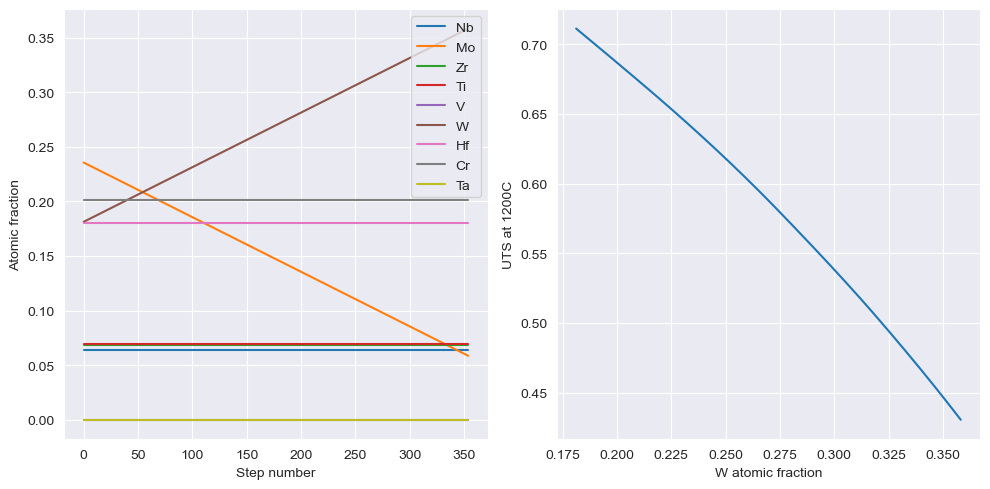

In [18]:
best_cand = np.array(best_cand).reshape(len(best_cand),-1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
to_consider = ['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta']
for el in to_consider:
    i = np.argwhere(np.array(el_list) == el).item()
    ax[0].plot(best_cand[:,i][::-1],label = el_list[i])

ax[0].set_xlabel('Step number')
ax[0].set_ylabel('Atomic fraction')
ax[0].legend()

ax[1].plot(best_cand[:,w_ind], best_cand_uts)
ax[1].set_ylabel('UTS at 1200C')
ax[1].set_xlabel('W atomic fraction')

plt.tight_layout()

In [9]:
forward_dict = {
    'forward':{
        'best_cands':best_cand[::-1].tolist(),
        'best_cand_uts':best_cand_uts[::-1],
        'w_content':best_cand[:,w_ind][::-1].tolist()
    }
}

In [18]:
def get_comp(vec, elem_list, thresh=0.02):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x > 0:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)
get_comp(best_cand[::-1][0][0], el_list)


Comp: Hf0.18 Zr0.07 Ti0.07 Nb0.06 Cr0.2 Mo0.24 W0.18

In [10]:
with open('results.json','r') as fid:
    temp_dict = json.load(fid)

In [11]:
# results_dict = temp_dict|forward_dict
# with open('results.json','w') as fid:
#     json.dump(results_dict,fid)

additional analysis

In [27]:
import torch

uts_model_loc = 'forward_v_inverse/saved_models/uts_model.pt'
uts_model = torch.jit.load(uts_model_loc, map_location='cpu')
weights = sum(p.numel() for p in uts_model.parameters() if p.requires_grad)
print( f'model has {weights} trainable weights' )

model has 1251 trainable weights


# search

In [35]:
orig = np.array(json_dict['start_comp']).reshape(1,-1)
print(orig, orig.shape)

[[0.         0.         0.         0.20112187 0.         0.
  0.18028086 0.         0.05807044 0.06428983 0.         0.
  0.         0.         0.06899341 0.         0.06850126 0.35874233]] (1, 18)


In [166]:
at_frac.flatten()

array([0.        , 0.        , 0.        , 0.20112187, 0.        ,
       0.        , 0.18028086, 0.        , 0.05807044, 0.06428983,
       0.        , 0.        , 0.        , 0.        , 0.06899341,
       0.        , 0.06850126, 0.35874233])

/Users/wfr5091/opt/anaconda3/envs/forward_v_inverse/lib/python3.10/site-packages/pygad/pygad.py:503: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))
/Users/wfr5091/opt/anaconda3/envs/forward_v_inverse/lib/python3.10/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of 

The slowest run took 4.86 times longer than the fastest. This could mean that an intermediate result is being cached.
3.03 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


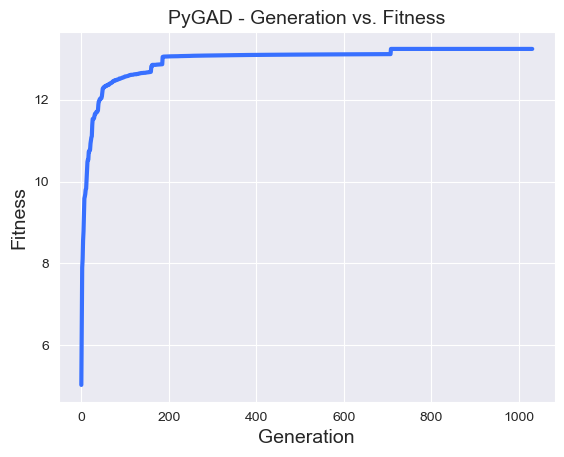

In [371]:
import pygad

def elu(x, alpha=1):
	return np.array([z if z >= 0.01 else alpha*(np.exp(z) -1) for z in x])

orig = np.array(json_dict['start_comp']).reshape(1, -1)
ele_map = [i for i, el in enumerate(el_list) if el in to_consider]

def fitness_fn(solution, solutionidx):
    norm_chem = np.zeros(len(el_list))
    norm_chem[ele_map] = np.array(solution).round(3)
    # if len(np.array(solution).shape) == 1:
    #     solution = [solution]
    norm_chem = norm_chem / np.sum(norm_chem)
    norm_chem[norm_chem <= 1e-2] = 0
    norm_chem /= np.sum(norm_chem)
    # np.array(norm_chem).reshape(1,-1)
    uts_temp = get_uts_without_grain(norm_chem.reshape(1, -1)).item()
    comp_dist = np.linalg.norm(norm_chem[:-1]-orig[0, :-1])
    W_content = np.abs(norm_chem[-1] - 0.175)
    #      max UTS    min dist    min W       min elements
    return 10 * uts_temp - comp_dist - W_content - 0.1 * np.sum(norm_chem>1e-2)


ga_instance = pygad.GA(num_generations=128,
                    num_parents_mating=8,
                    fitness_func=fitness_fn,
                    sol_per_pop=32,
                    num_genes=len(to_consider),
                    init_range_low=0,
                    init_range_high=1,
                    random_mutation_min_val=0,
                    random_mutation_max_val=1,
                    parent_selection_type="sss",
                    keep_parents=-1,
                    crossover_type="two_points",
                    mutation_type="random",
                    mutation_percent_genes=10,
                    save_solutions=True,
                    )

%timeit ga_instance.run()
_ = ga_instance.plot_fitness()

In [370]:
top_k = 3
u, u_idx = np.unique(np.array(ga_instance.solutions).round(2), axis=0, return_index=True)
u_fit = np.array([ga_instance.solutions_fitness[i] for i in u_idx])
top_idx = np.argsort(u_fit)[::-1][:top_k]
x_ga = np.array([u[i] for i in top_idx])
x_ga = x_ga / np.sum(x_ga, axis=1).reshape(-1, 1)
x_ga[x_ga <= 1e-2] = 0
x_ga = x_ga / np.sum(x_ga, axis=1).reshape(-1, 1)
pd.DataFrame(x_ga.round(3), columns=[el_list[i] for i in ele_map])

print( decode(x_ga[0].round(3), [el_list[i] for i in ele_map]) )

solution = x_ga[0]
norm_chem = np.zeros(len(el_list))
norm_chem[ele_map] = np.array(solution).round(3)
# if len(np.array(solution).shape) == 1:
#     solution = [solution]
norm_chem = norm_chem / np.sum(norm_chem)
norm_chem[norm_chem <= 1e-2] = 0
norm_chem /= np.sum(norm_chem)
# np.array(norm_chem).reshape(1,-1)
print( get_uts_without_grain(norm_chem.reshape(1, -1)).item() )

Hf0.03 Mo0.93 Ti0.04
1.4057244062423706


Cr0.17 Hf0.26 Mo0.21 Ti0.18 W0.19
0.8247047066688538


## with bayes opt

In [372]:
%%timeit

from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer


orig = np.array(json_dict['start_comp']).reshape(1, -1)
ele_map = [i for i, el in enumerate(el_list) if el in to_consider]
w_idx = [i for i, el in enumerate(el_list) if el == 'W'][0]
not_w_idx = [i for i, el in enumerate(el_list) if el != 'W']


def bo_fitness_fn(**solution_dict):
    solution = np.array([solution_dict[ele] if ele in solution_dict else 0 for ele in el_list])
    try:
        norm_chem = solution / np.sum(solution)
        norm_chem[norm_chem <= 1e-2] = 0
        norm_chem /= np.sum(norm_chem)
    except:
        return -1e3
    # np.array(norm_chem).reshape(1,-1)
    uts_temp = get_uts_without_grain(norm_chem.reshape(1, -1)).item()
    comp_dist = np.linalg.norm(norm_chem[not_w_idx]-orig[0, not_w_idx])
    W_content = np.abs(norm_chem[w_idx] - 0.175)
    #           max UTS    min dist    min W       min elements
    # objective = uts_temp - 5 * comp_dist - 10 * W_content - 0.5 * np.sum(norm_chem>1e-2)
    objective = 2 * uts_temp - 4 * comp_dist - W_content - 0.1 * np.sum(norm_chem>1e-2)
    if np.isnan(objective):
        return -1e3
    else:
        return objective


# Bounded region of parameter space
pbounds = {ele: (0, 1) for ele in to_consider}
# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)

optimizer = BayesianOptimization(
    f=bo_fitness_fn,
    pbounds=pbounds,
    random_state=0,
    # bounds_transformer=bounds_transformer,
)

optimizer.maximize(
    init_points=10, n_iter=40,
    # acq="ei", xi=0,
    # acq="ucb", kappa=10,# kappa_decay=1-1e-3,
)

|   iter    |  target   |    Cr     |    Hf     |    Mo     |    Nb     |    Ta     |    Ti     |     V     |     W     |    Zr     |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -1.039    | 0.5488    | 0.7152    | 0.6028    | 0.5449    | 0.4237    | 0.6459    | 0.4376    | 0.8918    | 0.9637    |
| 2         | -1.494    | 0.3834    | 0.7917    | 0.5289    | 0.568     | 0.9256    | 0.07104   | 0.08713   | 0.02022   | 0.8326    |
| 3         | -0.4163   | 0.7782    | 0.87      | 0.9786    | 0.7992    | 0.4615    | 0.7805    | 0.1183    | 0.6399    | 0.1434    |
| 4         | -1.557    | 0.9447    | 0.5218    | 0.4147    | 0.2646    | 0.7742    | 0.4562    | 0.5684    | 0.01879   | 0.6176    |
| 5         | -1.374    | 0.6121    | 0.6169    | 0.9437    | 0.6818    | 0.3595    | 0.437     | 0.6976    | 0.06023   | 0.6668    |
| 6         | -1.294    | 0.6706    | 0.2104    | 0.1289    | 

In [356]:
solution_dict = optimizer.max['params']
solution = np.array([solution_dict[ele] if ele in solution_dict else 0 for ele in el_list])
# solution = orig.flatten()
solution += np.random.randn(*solution.shape) * 0.05
norm_chem = solution / np.sum(solution)
norm_chem[norm_chem <= 1e-2] = 0
norm_chem /= np.sum(norm_chem)
print( norm_chem )
print( decode(norm_chem, el_list) )
print( get_uts_without_grain(norm_chem.reshape(1, -1)).item() )

uts_temp = get_uts_without_grain(norm_chem.reshape(1, -1)).item()
comp_dist = np.linalg.norm(norm_chem[not_w_idx]-orig[0, not_w_idx])
W_content = np.abs(norm_chem[w_idx] - 0.175)
#     max UTS    min dist    min W       min elements
print(uts_temp, comp_dist, W_content, np.sum(norm_chem>1e-2))

[0.         0.         0.         0.19015275 0.         0.
 0.25564858 0.         0.18365271 0.         0.         0.01890748
 0.         0.         0.16488289 0.02635656 0.         0.16039903]
Cr0.2 Hf0.27 Mo0.19 Ti0.17 W0.17
0.8672997355461121
0.8672997355461121 0.21277272454176419 0.006996448471713185 5
